True informative feature indices: [np.int64(0), np.int64(4), np.int64(5), np.int64(8)]
Feature names: ['dep_0', 'dep_1', 'dep_2', 'dep_3', 'dep_4', 'ind_0', 'ind_1', 'ind_2', 'ind_3', 'ind_4']


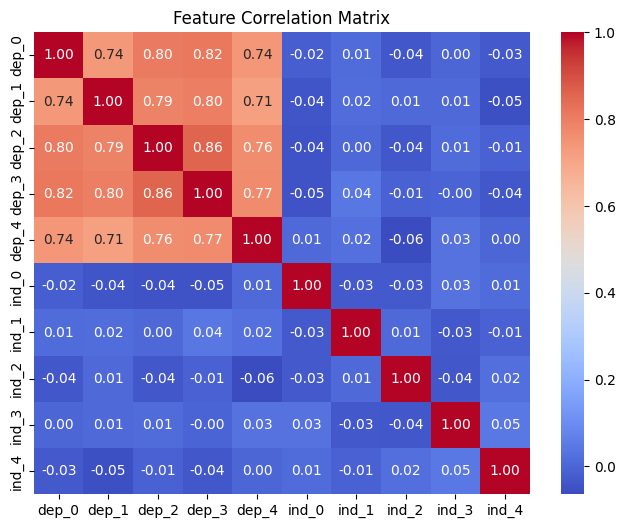

Generation 1: Best fitness = -1.7019, Features selected = 8
Generation 2: Best fitness = -1.6276, Features selected = 6
Generation 3: Best fitness = -1.5210, Features selected = 5
Generation 4: Best fitness = -1.4450, Features selected = 4
Generation 5: Best fitness = -1.4450, Features selected = 4
Generation 6: Best fitness = -1.4450, Features selected = 4
Generation 7: Best fitness = -1.4450, Features selected = 4
Generation 8: Best fitness = -1.4450, Features selected = 4
Generation 9: Best fitness = -1.4450, Features selected = 4
Generation 10: Best fitness = -1.4450, Features selected = 4
Generation 11: Best fitness = -1.4450, Features selected = 4
Generation 12: Best fitness = -1.4450, Features selected = 4
Generation 13: Best fitness = -1.4450, Features selected = 4
Generation 14: Best fitness = -1.4450, Features selected = 4
Generation 15: Best fitness = -1.4450, Features selected = 4
Generation 16: Best fitness = -1.4450, Features selected = 4
Generation 17: Best fitness = -1.

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# --- 1. Synthetic Data Generation Function ---
def generate_correlated_synthetic_data_v2(
    n_samples=1000,
    n_dependent=5,
    n_independent=5,
    n_inf_dep=2,      # Number of informative features from dependent group
    n_inf_ind=2,      # Number of informative features from independent group
    correlation_strength=0.95,
    target_noise=0.1,
    seed=None):
    if seed is not None:
        np.random.seed(seed)

    # Dependent (correlated) features
    latent_variable = np.random.randn(n_samples, 1)
    latent_weights = np.random.uniform(0.5, 1.0, size=(1, n_dependent)) * correlation_strength
    noise_std = np.sqrt(max(0, 1 - correlation_strength**2))
    dependent_noise = np.random.randn(n_samples, n_dependent) * noise_std
    X_dependent = latent_variable * latent_weights + dependent_noise

    # Independent features
    X_independent = np.random.randn(n_samples, n_independent)

    # Combine features
    X = np.hstack((X_dependent, X_independent))
    feature_names = [f'dep_{i}' for i in range(n_dependent)] + \
                    [f'ind_{i}' for i in range(n_independent)]
    n_total_features = n_dependent + n_independent

    # Select informative features
    if n_inf_dep > n_dependent or n_inf_ind > n_independent:
        raise ValueError("Number of informative features cannot exceed group size.")
    inf_dep_indices = np.random.choice(np.arange(n_dependent), size=n_inf_dep, replace=False)
    ind_pool_indices = np.arange(n_dependent, n_total_features)
    inf_ind_indices = np.random.choice(ind_pool_indices, size=n_inf_ind, replace=False)
    true_informative_indices = sorted(list(np.concatenate([inf_dep_indices, inf_ind_indices])))

    # Target variable
    true_coeffs = np.zeros(n_total_features)
    informative_coeffs = np.random.uniform(1, 5, size=len(true_informative_indices)) * \
                         np.random.choice([-1, 1], size=len(true_informative_indices))
    true_coeffs[true_informative_indices] = informative_coeffs
    y = X @ true_coeffs + np.random.randn(n_samples) * target_noise

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, true_informative_indices, feature_names

# --- 2. Generate Synthetic Dataset ---
num_samples = 1000
num_dependent_features = 5
num_independent_features = 5
num_informative_dependent = 2
num_informative_independent = 2
correlation_level = 0.95
noise_level = 0.2
random_seed = 42

X_scaled, y, true_indices, feature_names = generate_correlated_synthetic_data_v2(
    n_samples=num_samples,
    n_dependent=num_dependent_features,
    n_independent=num_independent_features,
    n_inf_dep=num_informative_dependent,
    n_inf_ind=num_informative_independent,
    correlation_strength=correlation_level,
    target_noise=noise_level,
    seed=random_seed
)

print(f"True informative feature indices: {true_indices}")
print(f"Feature names: {feature_names}")

# --- 3. Visualize Correlation Matrix (Optional) ---
X_df = pd.DataFrame(X_scaled, columns=feature_names)
plt.figure(figsize=(8, 6))
sns.heatmap(X_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# --- 4. Split Data for Fitness Evaluation ---
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
n_features = X_train.shape[1]

# --- 5. Hybrid Genetic Algorithm for Feature Selection ---
# GA Parameters
POP_SIZE = 30
N_GEN = 30
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.1
ELITISM = True
N_ELITE = 1
LOCAL_SEARCH_STEPS = 5
LS_TOP_K = 3
PENALTY_COEFF = 0.01

def fitness_function(individual):
    if np.sum(individual) == 0:
        return -np.inf
    selected = np.where(individual == 1)[0]
    X_train_sel = X_train[:, selected]
    X_val_sel = X_val[:, selected]
    model = RandomForestRegressor(n_estimators=50, random_state=42)
    model.fit(X_train_sel, y_train)
    y_pred = model.predict(X_val_sel)
    mse = mean_squared_error(y_val, y_pred)
    fitness = -mse - PENALTY_COEFF * np.sum(individual)
    return fitness

def initialize_population(pop_size, n_features):
    return np.random.randint(0, 2, size=(pop_size, n_features))

def tournament_selection(pop, fitnesses, k=3):
    selected = []
    for _ in range(len(pop)):
        idx = np.random.choice(len(pop), k)
        winner = idx[np.argmax(fitnesses[idx])]
        selected.append(pop[winner])
    return np.array(selected)

def uniform_crossover(parent1, parent2):
    mask = np.random.rand(len(parent1)) < 0.5
    child = np.where(mask, parent1, parent2)
    return child

def mutate(individual, mutation_rate):
    mutant = individual.copy()
    for i in range(len(mutant)):
        if np.random.rand() < mutation_rate:
            mutant[i] = 1 - mutant[i]
    return mutant

def local_search(individual, fitness_func, steps=5):
    best = individual.copy()
    best_fitness = fitness_func(best)
    for _ in range(steps):
        idx = np.random.randint(len(best))
        candidate = best.copy()
        candidate[idx] = 1 - candidate[idx]
        candidate_fitness = fitness_func(candidate)
        if candidate_fitness > best_fitness:
            best = candidate
            best_fitness = candidate_fitness
    return best

def hybrid_ga_feature_selection():
    population = initialize_population(POP_SIZE, n_features)
    best_fitnesses = []
    best_individual = None
    best_fit = -np.inf
    features_selected_history = []

    for gen in range(N_GEN):
        fitnesses = np.array([fitness_function(ind) for ind in population])
        gen_best_idx = np.argmax(fitnesses)
        if fitnesses[gen_best_idx] > best_fit:
            best_fit = fitnesses[gen_best_idx]
            best_individual = population[gen_best_idx].copy()
        best_fitnesses.append(best_fit)
        features_selected_history.append(np.sum(best_individual))

        # Elitism
        if ELITISM:
            elite_indices = np.argsort(fitnesses)[-N_ELITE:]
            elites = population[elite_indices]
        else:
            elites = np.empty((0, n_features), dtype=int)

        # Selection
        selected = tournament_selection(population, fitnesses)
        # Crossover
        offspring = []
        for i in range(0, POP_SIZE, 2):
            parent1 = selected[i]
            parent2 = selected[(i+1) % POP_SIZE]
            if np.random.rand() < CROSSOVER_RATE:
                child1 = uniform_crossover(parent1, parent2)
                child2 = uniform_crossover(parent2, parent1)
            else:
                child1, child2 = parent1.copy(), parent2.copy()
            offspring.extend([child1, child2])
        offspring = np.array(offspring[:POP_SIZE])

        # Mutation
        for i in range(POP_SIZE):
            offspring[i] = mutate(offspring[i], MUTATION_RATE)

        # Local Search on top individuals
        fitnesses_offspring = np.array([fitness_function(ind) for ind in offspring])
        top_indices = np.argsort(fitnesses_offspring)[-LS_TOP_K:]
        for idx in top_indices:
            offspring[idx] = local_search(offspring[idx], fitness_function, steps=LOCAL_SEARCH_STEPS)

        # Elitism: replace worst with elites
        if ELITISM:
            worst_indices = np.argsort(fitnesses_offspring)[:N_ELITE]
            offspring[worst_indices] = elites
        population = offspring

        print(f"Generation {gen+1}: Best fitness = {best_fit:.4f}, Features selected = {np.sum(best_individual)}")

    return best_individual, best_fitnesses, features_selected_history

# --- 6. Run the Hybrid GA ---
best_solution, fitness_history, features_selected_history = hybrid_ga_feature_selection()

# --- 7. Results ---
selected_features = np.where(best_solution == 1)[0]
print("\nBest feature subset found:")
print("Selected feature indices:", selected_features)
print("Selected feature names:", [feature_names[i] for i in selected_features])
print("Number of features selected:", len(selected_features))
print("Fitness history:", fitness_history)
print("True informative feature indices (ground truth):", true_indices)

# --- 8. Plot Fitness Curve and Number of Features Selected ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fitness_history, marker='o')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('HGA Convergence Curve (Fitness)')

plt.subplot(1, 2, 2)
plt.plot(features_selected_history, marker='s', color='orange')
plt.xlabel('Generation')
plt.ylabel('Number of Features Selected')
plt.title('Number of Features Selected per Generation')

plt.tight_layout()
plt.show()
